Questions prof :
 - Ground Truth gris pour premières images
 - Méthode de calcul d'erreur (gris autour détection)

In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Nous utilisons cette fonction pour la reproductibilité des résultats
def set_seed():
    seed = 1952752
    random.seed(seed)
    np.random.seed(seed)
    cv2.setRNGSeed(seed)

In [3]:
def read_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [4]:
input_file_names = os.listdir('./TP2_data/highway/input/')
gt_file_names = os.listdir('./TP2_data/highway/groundtruth/')

input_images = [ read_image('./TP2_data/highway/input/'+str(path)) for path in input_file_names]
gt_images = [ read_image('./TP2_data/highway/groundtruth/'+str(path)) for path in gt_file_names]

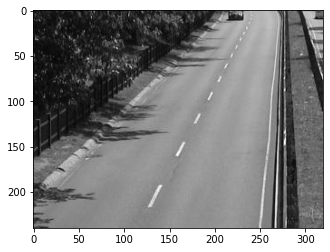

In [5]:
plt.figure()
plt.imshow(input_images[500], cmap=plt.get_cmap('gray'))
plt.show()

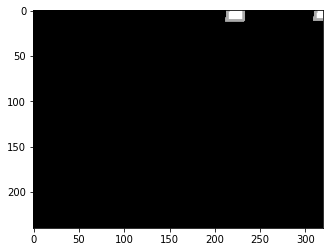

In [6]:
plt.figure()
plt.imshow(gt_images[500], plt.get_cmap('gray'))
plt.show()

# Soustraction d'arrière-plan

In [7]:
## Code from : https://github.com/yangshiyu89/VIBE 
def initial_background(I_gray, N):
    
    I_pad = np.pad(I_gray, 1, 'symmetric')
    height = I_pad.shape[0]
    width = I_pad.shape[1]
    samples = np.zeros((height,width,N))
    for i in tqdm(range(1, height - 1)):
        for j in range(1, width - 1):
            for n in range(N):
                x, y = 0, 0
                while(x == 0 and y == 0):
                    x = np.random.randint(-1, 1)
                    y = np.random.randint(-1, 1)
                ri = i + x
                rj = j + y
                samples[i, j, n] = I_pad[ri, rj]
    samples = samples[1:height-1, 1:width-1]
    return samples
    
def vibe_detection_and_update(I_gray, samples, _min, N, R):

    height = I_gray.shape[0]
    width = I_gray.shape[1]
    segMap = np.zeros((height, width)).astype(np.uint8)
    for i in range(height):
        for j in range(width):
            count, index, dist = 0, 0, 0
            while count < _min and index < N:
                dist = np.abs(I_gray[i,j] - samples[i,j,index])
                if dist < R:
                    count += 1
                index += 1
            if count >= _min:
                r = np.random.randint(0, N-1)
                if r == 0:
                    r = np.random.randint(0, N-1)
                    samples[i,j,r] = I_gray[i,j]
                r = np.random.randint(0, N-1)
                if r == 0:
                    x, y = 0, 0
                    while(x == 0 and y == 0):
                        x = np.random.randint(-1, 1)
                        y = np.random.randint(-1, 1)
                    r = np.random.randint(0, N-1)
                    ri = i + x
                    rj = j + y
                    try:
                        samples[ri, rj, r] = I_gray[i, j]
                    except:
                        pass
            else:
                segMap[i, j] = 255
    return segMap, samples

In [8]:
N = 20
R = 20
MIN = 2

def ViBE(input_images, N=N, R=R, MIN=MIN):
    print("Creating initial background ...")
    samples = initial_background(input_images[0], N)

    predictions = []
    print("Making predictions ...")
    for input_image in tqdm(input_images) : 
        segMap, samples = vibe_detection_and_update(input_image, samples, MIN, N, R)
        predictions.append(segMap)
    return predictions

In [29]:
GRAY_OUTLINE = 170
NO_PRED = 85

def segmentation_accuracy_recall_precision(truth, pred):
    total_size = truth.shape[0] * truth.shape[1]
    
    truth[truth == GRAY_OUTLINE] = pred[truth == GRAY_OUTLINE]
    correct_T_or_F = np.sum(truth == pred)
    accuracy = (correct_T_or_F+0.01)/(total_size+0.01)
    
    tp = np.sum(truth[truth==255] == pred[truth==255])
    recall = (tp+0.01)/(np.sum(truth==255)+0.01)
    precision = (tp+0.01)/(np.sum(pred==255)+0.01)
    
    f1 = 2*precision*recall/(precision+recall)
    
    return accuracy, recall, precision, f1

def get_metrics(gt_images, predictions):
    accuracy = []
    recall = []
    precision = []
    f1_score = []
    
    for i in tqdm(range(len(predictions))):
        if gt_images[i][0,0] == NO_PRED:
            continue
        acc, re, pre, f1 = segmentation_accuracy_recall_precision(gt_images[i], predictions[i])
        accuracy.append(acc)
        recall.append(re)
        precision.append(pre)
        f1_score.append(f1)
    
    return accuracy, recall, precision, f1_score

In [44]:
def display_metrics(metrics, video_name, method):
    print("Average accuracy : " + str(np.mean(metrics[0])))
    print("Average recall : " + str(np.mean(metrics[1])))
    print("Average precision : " + str(np.mean(metrics[2])))
    print("Average f1 score : " + str(np.mean(metrics[3])))
    
    plt.plot(metrics[0])
    plt.xlabel("Image Number")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of video " + video_name + " using " + method)
    plt.show()
    
    plt.plot(metrics[1])
    plt.xlabel("Image Number")
    plt.ylabel("Recall")
    plt.title("Recall of video " + video_name + " using " + method)
    plt.show()
    
    plt.plot(metrics[2])
    plt.xlabel("Image Number")
    plt.ylabel("Precision")
    plt.title("Precision of video " + video_name + " using " + method)
    plt.show()
    
    plt.plot(metrics[3])
    plt.xlabel("Image Number")
    plt.ylabel("F1 score")
    plt.title("F1 score of video " + video_name + " using " + method)
    plt.show()

In [10]:
def execute_vibe_on(video_name, save_results=True):
    input_folder = './TP2_data/'+str(video_name)+'/input/'
    gt_folder = './TP2_data/'+str(video_name)+'/groundtruth/'

    input_file_names = os.listdir(input_folder)
    gt_file_names = os.listdir(gt_folder)

    print('Loading input images...')
    input_images = [ read_image('./TP2_data/'+video_name+'/input/'+path) for path in tqdm(input_file_names)]
    
    print('Loading groundtruth images ...')
    gt_images = [ read_image('./TP2_data/'+video_name+'/groundtruth/'+path) for path in tqdm(gt_file_names)]
    
    predictions = ViBE(input_images)
    
    if(save_results):
        for index, pred in tqdm(enumerate(predictions)):
            file_path = './TP2_data/'+video_name+'/predictions_vibe/r' + str(index+1).rjust(6, '0') +'.jpg'
            cv2.imwrite(file_path, pred)
    
    return get_metrics(gt_images, predictions)

In [51]:
execute_vibe_on("pedestrians", save_results=True)

Loading input images...


100%|█████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:09<00:00, 113.63it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:07<00:00, 149.92it/s]


Creating initial background ...


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:15<00:00, 15.47it/s]


Making predictions ...


100%|██████████████████████████████████████████████████████████████████████████████| 1099/1099 [34:48<00:00,  1.90s/it]
1099it [00:01, 624.20it/s]
100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 1431.46it/s]


(([0.9982638890898277,
   0.9982638890898277,
   0.9983101853807655,
   0.9982870372352967,
   0.9982870372352967,
   0.9982291668716242,
   0.9977662039622449,
   0.9975115743620863,
   0.9970370373799725,
   0.9960995374884795,
   0.9958217597428519,
   0.9959722226884001,
   0.9951620375969864,
   0.995682870870038,
   0.9952430561061277,
   0.9947800931967484,
   0.9951620375969864,
   0.9953240746152692,
   0.994409722869245,
   0.994432871014714,
   0.9948958339240933,
   0.9949652783605002,
   0.994097222905414,
   0.9936342599960347,
   0.9944212969419796,
   0.994791667269483,
   0.9940509266144761,
   0.9939236118143968,
   0.9943981487965106,
   0.9948263894876864,
   0.995416667197145,
   0.995729167160976,
   0.9954398153426139,
   0.9956597227245692,
   0.9956712967973036,
   0.9956597227245692,
   0.9955092597790208,
   0.9956365745791002,
   0.9956250005063657,
   0.9955555560699588,
   0.9956134264336312,
   0.9950462968696415,
   0.9949189820695623,
   0.9953356486880

In [61]:
def load_predictions_and_get_metrics(video_name, suffix):
    prediction_folder_name = 'predictions_' + suffix
    
    prediction_folder = './TP2_data/'+str(video_name)+'/'+str(prediction_folder_name)+'/'
    gt_folder = './TP2_data/'+str(video_name)+'/groundtruth/'

    predictions_file_names = os.listdir(prediction_folder)
    gt_file_names = os.listdir(gt_folder)

    print('Loading prediction images...')
    predictions = [ read_image(prediction_folder+path) for path in tqdm(predictions_file_names)]
    
    print('Loading groundtruth images ...')
    gt_images = [ read_image(gt_folder+path) for path in tqdm(gt_file_names)]
    
    print("Calculating accuracy ...")
    return get_metrics(gt_images, predictions)

In [39]:
metrics = load_predictions_and_get_metrics("highway", 'vibe')

Loading prediction images...


100%|█████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:10<00:00, 161.97it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:01<00:00, 997.85it/s]


Calculating accuracy ...


100%|████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:01<00:00, 1627.04it/s]


Average accuracy : 0.9386150926969966
Average recall : 0.6513747457100227
Average precision : 0.8596518606562695
Average f1 score : 0.7352517801053685


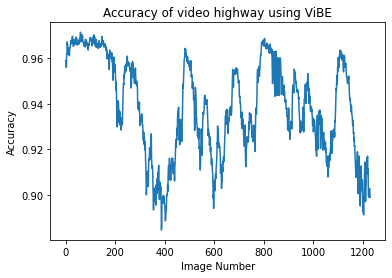

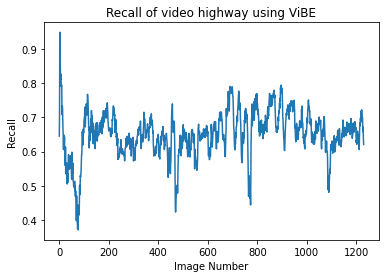

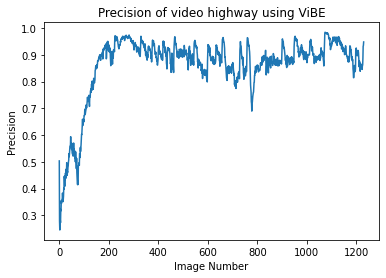

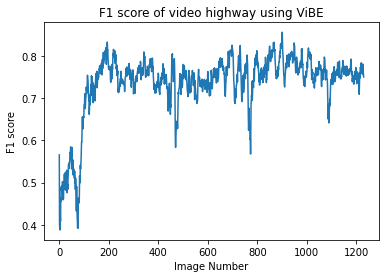

In [45]:
display_metrics(metrics, 'highway', 'ViBE')

In [46]:
metrics = load_predictions_and_get_metrics("office", 'vibe')

Loading prediction images...


100%|█████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:11<00:00, 172.65it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:13<00:00, 155.78it/s]


Calculating accuracy ...


100%|█████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:02<00:00, 951.27it/s]


Average accuracy : 0.9431520231725197
Average recall : 0.687341405996915
Average precision : 0.938597300488321
Average f1 score : 0.778445397293297


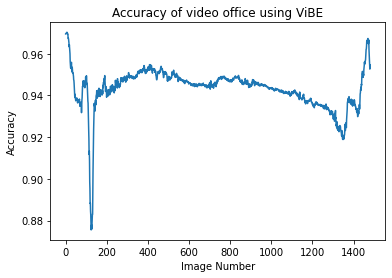

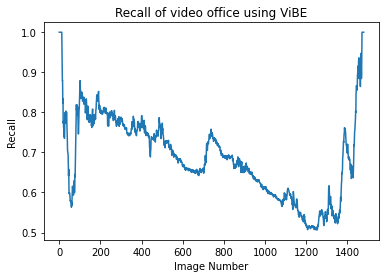

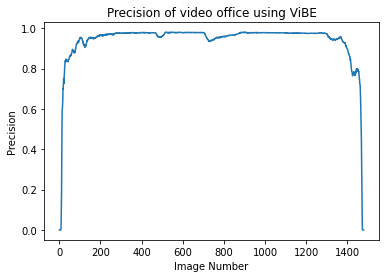

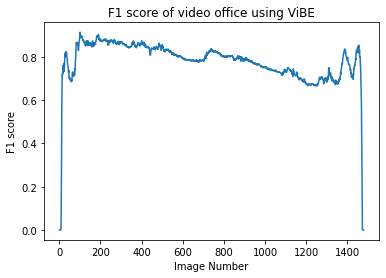

In [49]:
display_metrics(metrics, 'office', 'ViBE')

In [52]:
metrics = load_predictions_and_get_metrics("pedestrians", 'vibe')

Loading prediction images...


100%|█████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:05<00:00, 196.71it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:01<00:00, 941.25it/s]


Calculating accuracy ...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 1541.96it/s]


Average accuracy : 0.9802002482407118
Average recall : 0.7962219312219909
Average precision : 0.7233717051087362
Average f1 score : 0.6458059011036739


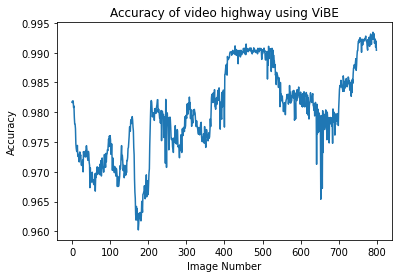

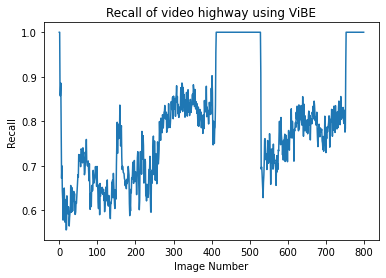

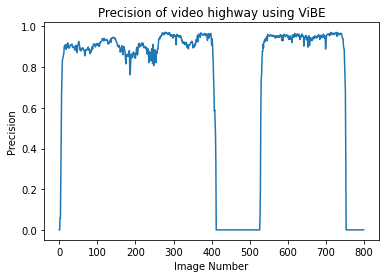

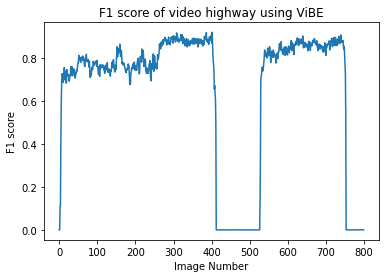

In [53]:
display_metrics(metrics, 'pedestrians', 'ViBE')

In [ ]:
metrics = load_predictions_and_get_metrics("PETS2006", 'vibe')

In [ ]:
display_metrics(metrics, 'PETS2006', 'ViBE')

# Segmentation Sémantique

Afin de pouvoir utiliser le GPU et accélérer le tout, les prédictions avec la segmentation sémantique ont été faites sur Google Colab et ont été sauvegardé en local par la suite pour pouvoir faire la comparaison ici ! Le notebook utilisé sur colab est aussi disponible dans le même fichier que celui-ci.

In [54]:
metrics = load_predictions_and_get_metrics("highway", 'deeplab')

Loading prediction images...


100%|█████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:16<00:00, 105.97it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:03<00:00, 442.42it/s]


Calculating accuracy ...


100%|████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:01<00:00, 1405.14it/s]


Average accuracy : 0.976065045934023
Average recall : 0.7177398336074458
Average precision : 0.9757227556235
Average f1 score : 0.8096452406181756


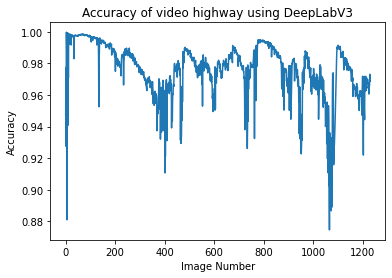

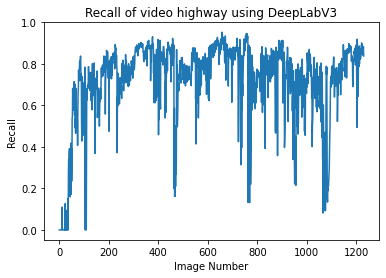

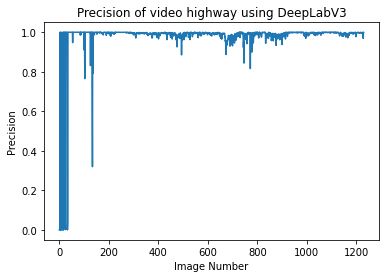

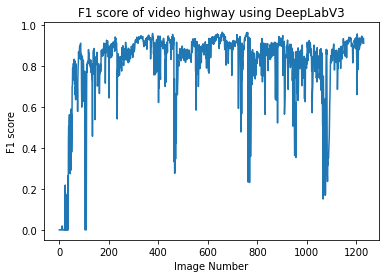

In [55]:
display_metrics(metrics, 'highway', 'DeepLabV3')

In [56]:
metrics = load_predictions_and_get_metrics("office", 'deeplab')

Loading prediction images...


100%|██████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:22<00:00, 91.02it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:02<00:00, 761.96it/s]


Calculating accuracy ...


100%|████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:01<00:00, 1523.99it/s]


Average accuracy : 0.9812166632138354
Average recall : 0.8778151276299357
Average precision : 0.9603318428048794
Average f1 score : 0.907247276819812


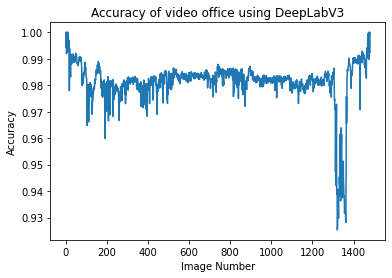

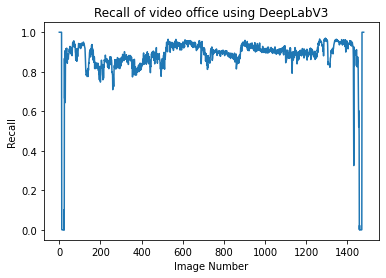

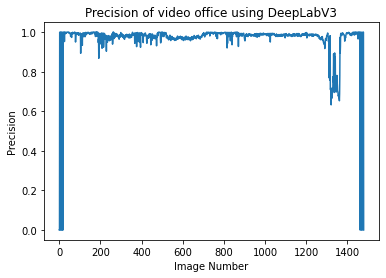

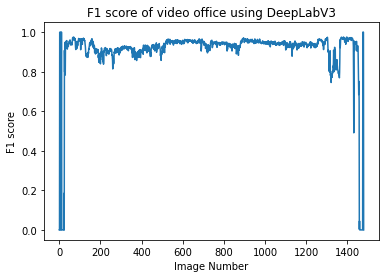

In [57]:
display_metrics(metrics, 'office', 'DeepLabV3')

In [66]:
metrics = load_predictions_and_get_metrics("pedestrians", 'deeplab_with_bicycle')

Loading prediction images...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 2598.51it/s]


Loading groundtruth images ...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:01<00:00, 1039.67it/s]


Calculating accuracy ...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 1385.11it/s]


Average accuracy : 0.9701264068140734
Average recall : 0.7394876810601678
Average precision : 0.32633003643930153
Average f1 score : 0.40101781494276023


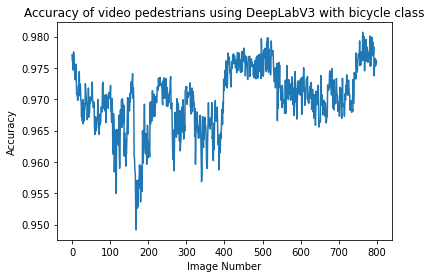

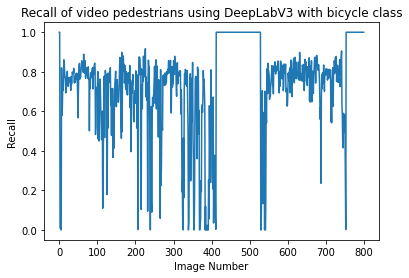

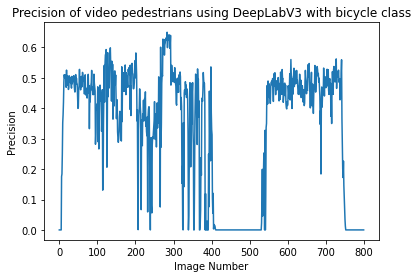

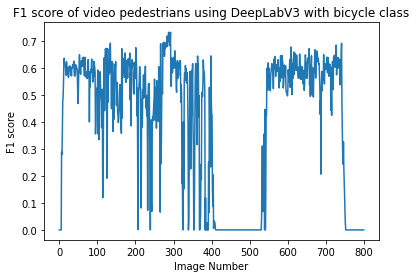

In [67]:
display_metrics(metrics, 'pedestrians', 'DeepLabV3 with bicycle class')

In [58]:
metrics = load_predictions_and_get_metrics("pedestrians", 'deeplab_without_bicycle')

Loading prediction images...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 1658.59it/s]


Loading groundtruth images ...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 1385.87it/s]


Calculating accuracy ...


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 1430.81it/s]


Average accuracy : 0.9884682449689531
Average recall : 0.7367796573030335
Average precision : 0.6236562744900419
Average f1 score : 0.5649522258824422


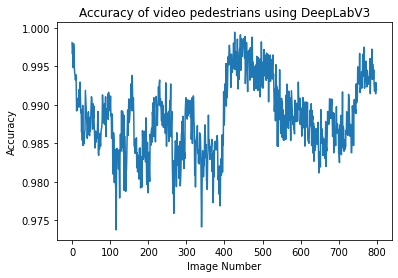

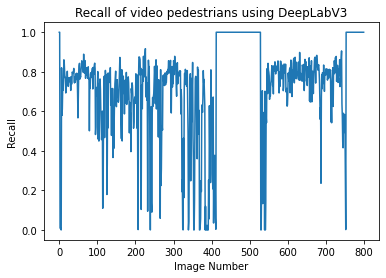

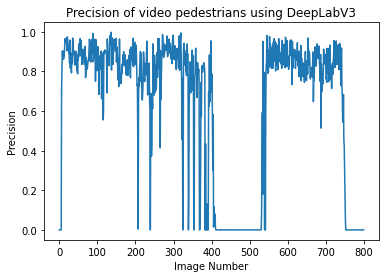

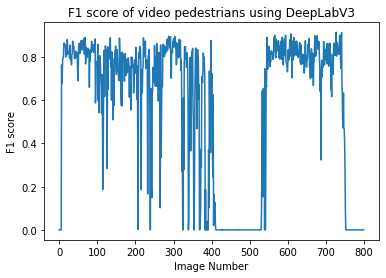

In [59]:
display_metrics(metrics, 'pedestrians', 'DeepLabV3 without bicycle class')

In [62]:
metrics = load_predictions_and_get_metrics("PETS2006", 'deeplab_with_train')

Loading prediction images...


100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:12<00:00, 94.43it/s]


Loading groundtruth images ...


100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:12<00:00, 98.10it/s]


Calculating accuracy ...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:03<00:00, 367.52it/s]


Average accuracy : 0.7516253219958786
Average recall : 0.8220545824036775
Average precision : 0.050713347745110195
Average f1 score : 0.0939780307913722


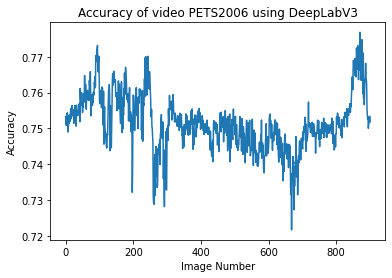

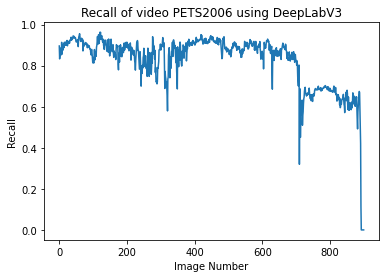

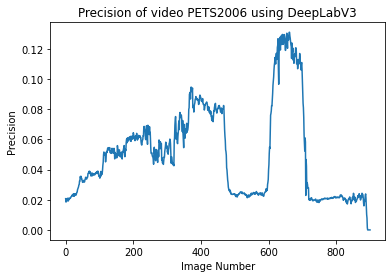

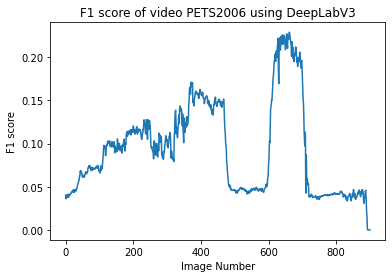

In [63]:
display_metrics(metrics, 'PETS2006', 'DeepLabV3 with train class')

In [64]:
metrics = load_predictions_and_get_metrics("PETS2006", 'deeplab_without_train')

Loading prediction images...


100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:19<00:00, 63.16it/s]


Loading groundtruth images ...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 188.91it/s]


Calculating accuracy ...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 195.92it/s]


Average accuracy : 0.9947396626759973
Average recall : 0.732824327030396
Average precision : 0.9648641800009073
Average f1 score : 0.8204473401989608


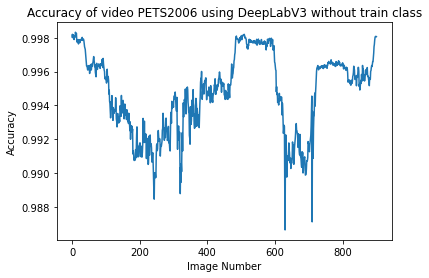

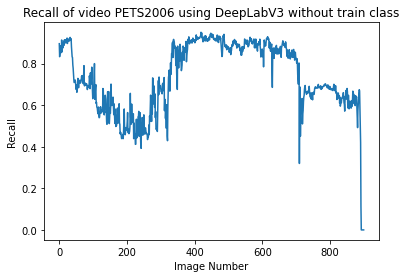

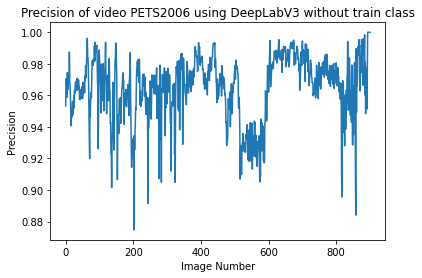

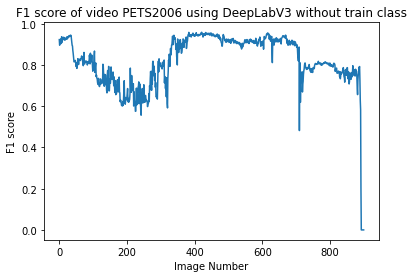

In [65]:
display_metrics(metrics, 'PETS2006', 'DeepLabV3 without train class')